# **Toxic Comment Classification**
### Experiment 3: Pre-trained Encoder Transformers - BERT


*   Aima Shahid
*   Aiman Mubasher
*   Emaan Attique
*   Emaan Bilal
*   Seemal Tausif
*   Zoha Hayat

## **Overview**
This code aims to implement a BERT-based text classification model for the Kaggle Toxic Comment Classification Challenge. It loads, preprocesses, and tokenizes the dataset, trains the model using PyTorch and the transformers library, and evaluates its performance on validation and test sets. The model is designed to classify toxic comments into multiple labels. Key steps include data preprocessing, tokenization, model training, and performance evaluation using various classification metrics. The dataset used in this project is sourced from Kaggle's Toxic Comment Classification Challenge, with the model's results visualized for better interpretation.

## **Loading and Installing packages**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries
!pip install transformers

In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

## **Data Loading and Preprocessing**
The data had to be preprocessed by removing the -1 labels from the test dataset since they were influencing the binary classification of the dataset. We used Bert-tokenizer to preprocess the data, which is discussed in the next section. This removed the requirement to manually preprocess the data.

In [ ]:
# Load the dataset
train_path = 'drive/MyDrive/Fall 2023/Machine Learning/dataset/train.csv'
test_path = 'drive/MyDrive/Fall 2023/Machine Learning/dataset/test.csv'
test_labels_path = 'drive/MyDrive/Fall 2023/Machine Learning/dataset/test_labels.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
test_labels = pd.read_csv(test_labels_path)

In [ ]:
print(train_data.shape)
train_data.head(10)

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
# Merge test data and labels
test_data = pd.merge(test_data, test_labels, on='id')
print(test_data.shape)
test_data.head(10)

(153164, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,-1,-1,-1,-1,-1,-1


In [ ]:
test_data = test_data.loc[~(test_data == -1).any(axis=1)]
print(test_data.shape)
test_data.head(10)

(63978, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
16,000663aff0fffc80,this other one from 1897,0,0,0,0,0,0
17,000689dd34e20979,== Reason for banning throwing == \n\n This ar...,0,0,0,0,0,0
19,000844b52dee5f3f,|blocked]] from editing Wikipedia. |,0,0,0,0,0,0
21,00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
22,000968ce11f5ee34,Please stop. If you continue to vandalize Wiki...,0,0,0,0,0,0


In [ ]:
# Splitting the test dataset into test and validation set
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

## **Feature-engineering**
In this code, feature engineering primarily involves tokenization using the BERT tokenizer, a critical step in natural language processing. The text data is converted into numerical tokens, with sequences padded to a specified maximum length and truncated if needed. These tokenized sequences, along with the formatted labels indicating toxic behavior in multiple categories, are organized into DataLoader objects for batch processing during model training and evaluation. Additionally, the dataset undergoes a train-test split to enable model training on a subset and subsequent evaluation on unseen data. The feature engineering process ensures the input data is appropriately formatted and compatible with the BERT-based text classification model, aiming to classify toxic comments in the Kaggle Toxic Comment Classification Challenge.

In [ ]:
# Define and apply tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(text, max_length=128):
    tokens = tokenizer.encode_plus(text, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
    return tokens

# Tokenize train and test data
train_tokens = train_data['comment_text'].apply(tokenize_text)
test_tokens = test_data['comment_text'].apply(tokenize_text)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Create DataLoader
train_inputs = torch.cat([t['input_ids'] for t in train_tokens], dim=0)
train_masks = torch.cat([t['attention_mask'] for t in train_tokens], dim=0)
train_labels = torch.tensor(train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, dtype=torch.float32)

test_inputs = torch.cat([t['input_ids'] for t in test_tokens], dim=0)
test_masks = torch.cat([t['attention_mask'] for t in test_tokens], dim=0)
test_labels = torch.tensor(test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, dtype=torch.float32)

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

In [ ]:
val_tokens = val_data['comment_text'].apply(tokenize_text)

val_inputs = torch.cat([t['input_ids'] for t in val_tokens], dim=0)
val_masks = torch.cat([t['attention_mask'] for t in val_tokens], dim=0)
val_labels = torch.tensor(val_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, dtype=torch.float32)

val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## **Model Building**
The model architecture is defined using BertForSequenceClassification from the transformers library. This model is pre-trained on BERT and adapted for sequence classification. The AdamW optimizer is employed for training. So the train dataset was splitted into 80% train and 20% validation dataset. The model was first trained on this train dataset. We used 5 epochs for this model since the runtime was quite high for higher epochs and Colab's GPU did not allow to run the code file for a longer time. We used a learning rate of 0.00001 since higher values increased the loss on every epoch and lower values increased the runtime. The training loop iterates through batches of the training dataset, computes the loss, and updates the model parameters using backpropagation.

In [ ]:
# Defining and training the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    steps = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')

Epoch 1: 100%|██████████| 3990/3990 [41:46<00:00,  1.59it/s]


Epoch 1/5, Loss: 0.059258190048584264


Epoch 2: 100%|██████████| 3990/3990 [41:49<00:00,  1.59it/s]


Epoch 2/5, Loss: 0.036856961446956625


Epoch 3: 100%|██████████| 3990/3990 [41:49<00:00,  1.59it/s]


Epoch 3/5, Loss: 0.029848856730214472


Epoch 4: 100%|██████████| 3990/3990 [41:49<00:00,  1.59it/s]


Epoch 4/5, Loss: 0.024572013815200272


Epoch 5: 100%|██████████| 3990/3990 [41:49<00:00,  1.59it/s]

Epoch 5/5, Loss: 0.02024946868055886


In [ ]:
# Save the trained model
torch.save(model, 'drive/MyDrive/ML Project/dataset/saved_model4.pth')

In [44]:
# Loading the model
model = torch.load('drive/MyDrive/Fall 2023/Machine Learning/dataset/saved_model4.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## **Evaluation**
The metric that we used for evaluation between all three models is AUC-ROC.

**Model Evaluation on Validation Set:**
The trained model is evaluated on the validation set using metrics such as loss and AUC-ROC. The code also calculates and prints classification metrics, including accuracy, precision, recall, and F1 score, for each toxic comment category.

**Model Evaluation on Test Set:**
The model's performance is assessed on an unseen test dataset. Similar to the validation set evaluation, classification metrics are computed, and a detailed analysis of the results is provided.

In [ ]:
# Evaluating the model on validation data
model.eval()
val_loss = 0
all_val_preds = []
all_val_labels = []
loss_val = []

with torch.no_grad():
    for batch in tqdm(val_dataloader, desc=f'Validation'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        preds = torch.sigmoid(logits)
        all_val_preds.extend(preds.cpu().numpy())
        all_val_labels.extend(labels.cpu().numpy())

        val_loss += outputs.loss.item()

        loss_val.append(outputs.loss.item())

average_val_loss = val_loss / len(val_dataloader)
print(f'Validation, Loss: {average_val_loss}')

Validation: 100%|██████████| 998/998 [03:30<00:00,  4.74it/s]

Validation, Loss: 0.04832045249422809


In [ ]:
# Convert probabilities to binary predictions for validation set
val_threshold = 0.5
binary_val_preds = (np.array(all_val_preds) > val_threshold).astype(int)

# Print classification report for validation set
print("Classification Report for Validation Set:")
target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
report = classification_report(all_val_labels, binary_val_preds, target_names=target_names)
print(report)

accuracy = accuracy_score(all_val_labels, binary_val_preds)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Calculate and print weighted-average precision, recall, accuracy, and F1 score
weighted_precision = precision_score(all_val_labels, binary_val_preds, average='weighted')
weighted_recall = recall_score(all_val_labels, binary_val_preds, average='weighted')
weighted_f1 = f1_score(all_val_labels, binary_val_preds, average='weighted')

print(f'weighted-Average Precision: {weighted_precision:.4f}')
print(f'weighted-Average Recall: {weighted_recall:.4f}')
print(f'weighted-Average F1 Score: {weighted_f1:.4f}')

# Calculate and print AUC-ROC
auc_roc = roc_auc_score(all_val_labels, np.array(all_val_preds), average='weighted')
auc_roc_2 = roc_auc_score(all_val_labels, np.array(all_val_preds))
print(f'weighted-Average AUC-ROC: {auc_roc:.4f}')
print(f'AUC-ROC: {auc_roc_2:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Validation Set:
               precision    recall  f1-score   support

        toxic       0.79      0.86      0.82      3056
 severe_toxic       0.48      0.55      0.51       321
      obscene       0.79      0.86      0.82      1715
       threat       0.48      0.54      0.51        74
       insult       0.73      0.83      0.77      1614
identity_hate       0.51      0.62      0.56       294

    micro avg       0.75      0.82      0.78      7074
    macro avg       0.63      0.71      0.67      7074
 weighted avg       0.75      0.82      0.78      7074
  samples avg       0.07      0.08      0.07      7074

Validation Accuracy: 92.16%
weighted-Average Precision: 0.7488
weighted-Average Recall: 0.8240
weighted-Average F1 Score: 0.7845
weighted-Average AUC-ROC: 0.9863
AUC-ROC: 0.9885


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


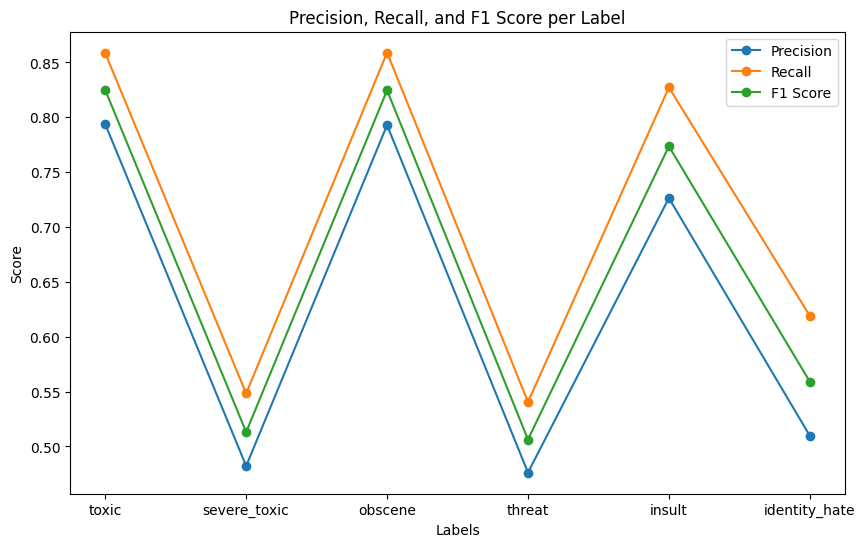

In [ ]:
report1 = classification_report(all_val_labels, binary_val_preds, target_names=target_names, output_dict=True)

# Extract precision, recall, and f1-score for each label
labels = target_names
precision = [report1[label]['precision'] for label in labels]
recall = [report1[label]['recall'] for label in labels]
f1_scores = [report1[label]['f1-score'] for label in labels]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(labels, precision, marker='o', label='Precision')
plt.plot(labels, recall, marker='o', label='Recall')
plt.plot(labels, f1_scores, marker='o', label='F1 Score')

plt.xlabel('Labels')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Label')
plt.legend()

plt.show()

Evaluating the model on the test dataset and then subsequently plotting the AUC-ROC curve and a graph to visualise the change in precision, recall and f1-score for each label.

In [ ]:
# Evaluate the model on test data
model.eval()
test_loss = 0
all_preds = []
all_labels = []
loss_test = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc=f'Testing'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        preds = torch.sigmoid(logits)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_loss += outputs.loss.item()

        loss_test.append(outputs.loss.item())

average_test_loss = test_loss / len(test_dataloader)
print(f'Testing, Loss: {average_test_loss}')

Testing: 100%|██████████| 2000/2000 [07:01<00:00,  4.74it/s]

Testing, Loss: 0.09007495319540612


In [ ]:
# Convert probabilities to binary predictions
threshold = 0.5
binary_preds = (np.array(all_preds) >= threshold).astype(int)

# Print classification report
target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
report = classification_report(all_labels, binary_preds, target_names=target_names)
print(report)

accuracy_test = accuracy_score(all_labels, binary_preds)
print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Calculate and print weighted-average precision, recall, accuracy, and F1 score
weighted_precision = precision_score(all_labels, binary_preds, average='weighted')
weighted_recall = recall_score(all_labels, binary_preds, average='weighted')
weighted_f1_sc = f1_score(all_labels, binary_preds, average='weighted')

print(f'weighted-Average Precision: {weighted_precision:.4f}')
print(f'weighted-Average Recall: {weighted_recall:.4f}')
print(f'weighted-Average F1 Score: {weighted_f1_sc:.4f}')

# Calculate and print AUC-ROC
auc_roc = roc_auc_score(all_labels, np.array(all_preds), average='weighted')
auc_roc_2 = roc_auc_score(all_val_labels, np.array(all_val_preds))
print(f'weighted-Average AUC-ROC: {auc_roc:.4f}')
print(f'AUC-ROC: {auc_roc_2:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        toxic       0.51      0.90      0.65      6090
 severe_toxic       0.29      0.57      0.38       367
      obscene       0.57      0.82      0.67      3691
       threat       0.47      0.63      0.54       211
       insult       0.60      0.78      0.68      3427
identity_hate       0.51      0.70      0.59       712

    micro avg       0.54      0.83      0.65     14498
    macro avg       0.49      0.73      0.59     14498
 weighted avg       0.54      0.83      0.65     14498
  samples avg       0.08      0.08      0.07     14498

Test Accuracy: 85.84%
weighted-Average Precision: 0.5426
weighted-Average Recall: 0.8285
weighted-Average F1 Score: 0.6528
weighted-Average AUC-ROC: 0.9734
AUC-ROC: 0.9885


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


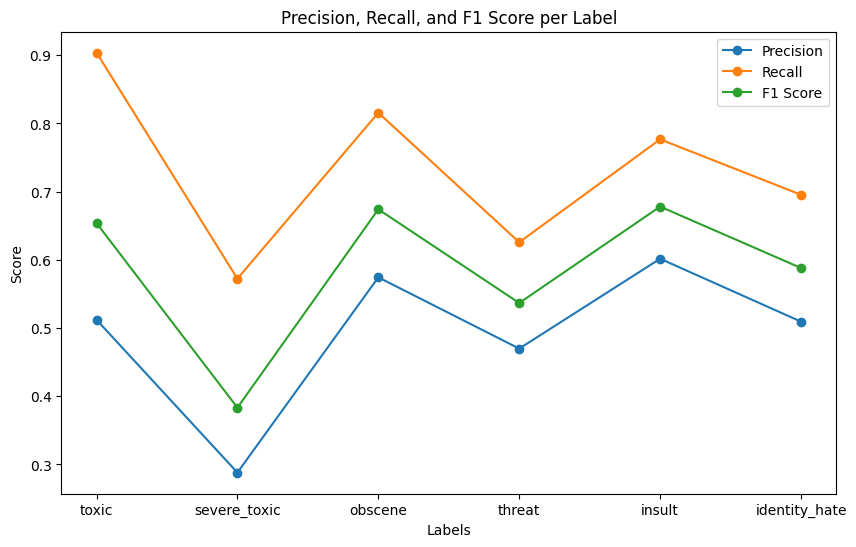

In [ ]:
report2 = classification_report(all_labels, binary_preds, target_names=target_names, output_dict=True)

# Extract precision, recall, and f1-score for each label
labels = target_names
precision = [report2[label]['precision'] for label in labels]
recall = [report2[label]['recall'] for label in labels]
f1_score = [report2[label]['f1-score'] for label in labels]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(labels, precision, marker='o', label='Precision')
plt.plot(labels, recall, marker='o', label='Recall')
plt.plot(labels, f1_score, marker='o', label='F1 Score')

plt.xlabel('Labels')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score per Label')
plt.legend()

plt.show()

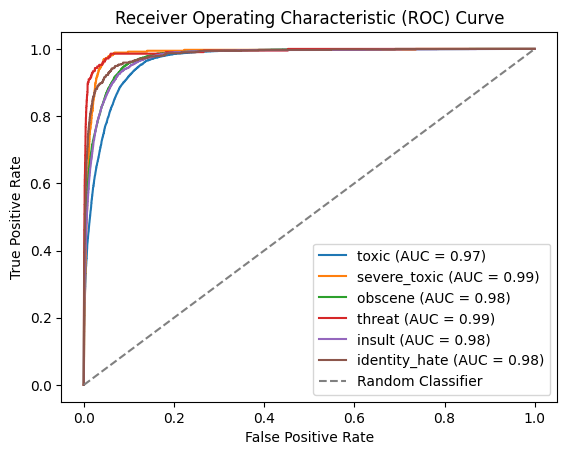

In [ ]:
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

all_labelss = np.array(all_labels)
all_predss = np.array(all_preds)

# Plot ROC curve for each label
for i, label in enumerate(label_names):
    fpr, tpr, _ = roc_curve(all_labelss[:, i], all_predss[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

# Plotting the random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

## **Results Interpretation**
In evaluating the model's performance, metrics including accuracy, precision, recall, and F1-score were employed, providing a comprehensive understanding of its effectiveness in toxic comment detection. The consideration of these metrics becomes crucial in the presence of potential class imbalances within the multi-label classification task. Class imbalances can impact the interpretation of accuracy, making precision, recall, and F1-score more informative measures. If certain toxic comment categories are underrepresented or overrepresented, accuracy alone may not accurately reflect the model's performance.

The class imbalances observed in the toxic comment classification task may have influenced the model's evaluation metrics, particularly impacting precision, recall, and potentially biasing the accuracy metric. In a multi-label classification scenario, class imbalances arise when certain toxic comment categories have significantly more or fewer instances than others. Here's how class imbalances may have affected the results:

1. **Precision and Recall Impact:**
   - **Precision:** With class imbalances, precision becomes sensitive to false positives. A lower precision suggests that the model may be incorrectly predicting positive instances in categories with fewer examples, contributing to a higher rate of false positives.
   - **Recall:** Class imbalances affect recall by influencing the model's ability to capture positive instances in underrepresented categories. A lower recall indicates a higher rate of false negatives, as the model might miss instances in minority classes.

2. **Accuracy Consideration:**
   - **Accuracy:** While accuracy is relatively high, it might not provide a complete picture of the model's performance, especially if the majority class dominates the dataset. Accuracy can be misleading in the presence of imbalances, as the model might achieve high accuracy by predominantly predicting the majority class.

3. **Weighted Metrics:**
   - **Weighted-Average Precision and Recall:** These metrics consider the imbalances by weighting precision and recall based on the number of instances in each class. A lower weighted-average precision indicates challenges in correctly identifying instances in underrepresented categories.
   - **Weighted-Average F1 Score:** Reflects the balance between precision and recall, offering a comprehensive metric considering both false positives and false negatives in the imbalanced setting.

4. **AUC-ROC:**
   - The Weighted Average Area Under the Receiver Operating Characteristic curve (Weighted AUC-ROC) is a key evaluation metric utilized in the provided code. AUC-ROC is commonly employed in binary and multi-label classification tasks to assess the model's ability to distinguish between positive and negative instances across different classification thresholds. The "weighted" aspect in Weighted AUC-ROC indicates that the metric considers class imbalances by assigning weights based on the number of instances in each class. This weighted approach provides a more nuanced understanding of the model's discriminatory power across various toxic comment categories. A higher Weighted AUC-ROC value, such as the reported 0.9734 in the code, suggests that the model performs well in distinguishing between toxic and non-toxic comments, considering both the overall classification performance and the distribution of instances among different classes.

## **Future Improvements**
1. Apply data augmentation techniques to diversify the training dataset.
2. Fine-tune the pre-trained BERT model for the specific toxic comment classification task.
3. Experiment with learning rates, batch sizes, and training epochs for optimal hyperparameter configurations.
4. Address class imbalances through oversampling, undersampling, or adjusting class weights during training.
5. Explore transfer learning and domain adaptation strategies to align the model with specific domain characteristics.
6. Implement regularization techniques like dropout during training to prevent overfitting.